In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
from keras import backend as K
import math
from tabulate import tabulate

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Attention, Activation, MaxPooling1D, Flatten, Dense, LSTM, Conv1D, Flatten, AveragePooling1D, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [106]:
from keras.models import load_model
model = tf.keras.models.load_model('588_simulator_stl.h5')

In [109]:
in_w = 180
interval = int(in_w/10*2)
out_w = 13

train_x = np.zeros((int((train.shape[0]-out_w*5-in_w)/5)+1, in_w, train.shape[1]))
train_y = np.zeros((int((train.shape[0]-out_w*5-in_w)/5)+1, out_w))

for i in range (0, train_x.shape[0]):
    train_x[i] = train[i*5:in_w+i*5]
    train_y[i] = train.iloc[np.where(train['BGL']>0)[0][interval+i:interval+(i)+out_w]]['BGL']
    
test_x = np.zeros((int((test.shape[0]-out_w*5-in_w)/5)+1, in_w, test.shape[1]))
test_y = np.zeros((int((test.shape[0]-out_w*5-in_w)/5)+1, out_w))

for i in range (0, test_x.shape[0]):
    test_x[i] = test[i*5:in_w+i*5]
    test_y[i] = test.iloc[np.where(test['BGL']>0)[0][interval+i:interval+i+out_w]]['BGL']

1/1 [==============================] - 1s 558ms/step


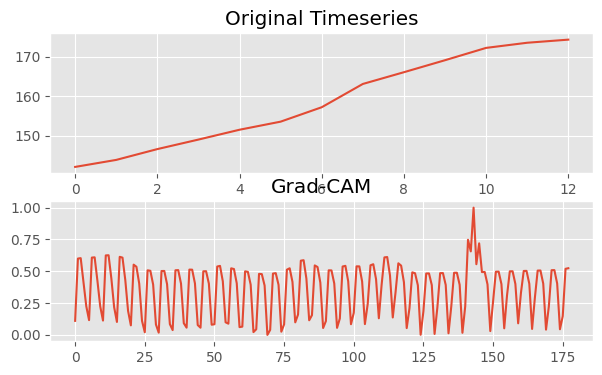

In [110]:
# Select a sample from your test dataset
X_sample = test_x[1255:1256,:,:]
y_sample = test_y[1255:1256,:]

# Get the predicted glucose values for the sample
y_pred = model.predict(X_sample)
# Get the index of the predicted glucose value with the highest value
target_index = np.argmax(y_pred)

# Get the convolutional layer output and the LSTM layer output
conv_output, lstm_output = model.layers[0], model.layers[5]
grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=[conv_output.output, lstm_output.output])

# Generate the gradients using GradientTape
with tf.GradientTape() as tape:
    lstm_output, loss = grad_model(X_sample, training=False)
grads = tape.gradient(loss, lstm_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
pooled_grads = tf.reshape(pooled_grads, (1, -1))  # Reshape the pooled gradients

final_output = lstm_output[0] * pooled_grads  # Perform the element-wise multiplication with broadcasting
cam = np.sum(final_output, axis=1)

# Normalize the class activation map
cam_norm = cv2.normalize(cam, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Plot the original timeseries and the corresponding class activation map
plt.style.use('ggplot')
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7,4))
axs[0].plot(y_sample[0])
axs[0].set_title('Original Timeseries')
axs[1].plot(cam_norm)
axs[1].set_title('Grad-CAM')

plt.show()

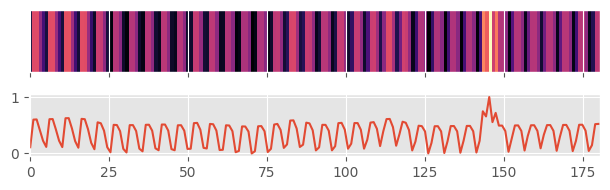

In [111]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 6.2,2

x = np.linspace(0,180, num=178)
y = cam_norm

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y[np.newaxis,:], cmap="magma", aspect="auto", extent=extent)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

ax2.plot(x,y)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'CHO (g)')

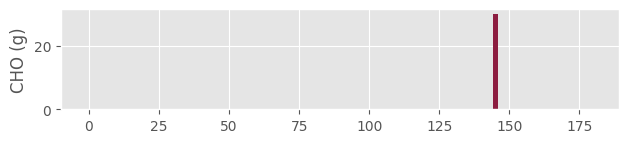

In [112]:
plt.figure(figsize=(7.2,1.3))
plt.bar(np.arange(0,180,1),X_sample[0,:,4], color='#8C1D40', width = 2)
plt.ylabel('CHO (g)')

1/1 [==============================] - 0s 32ms/step


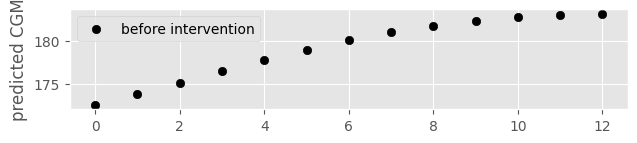

In [113]:
plt.figure(figsize=(7.2,1.3))
plt.scatter(np.arange(0,13,1),model.predict(X_sample)[0],c='black')
plt.ylabel('predicted CGM')
plt.legend(['before intervention'],loc='upper left')
plt.show()

In [114]:
carb = []
BGL = []

for modified_carb in range (math.ceil(X_sample[0,np.argmax(X_sample[0,:,4]),4]),4,-1):
  X_sample[0,np.argmax(X_sample[0,:,4]),4] = modified_carb
  y_pred = model.predict(X_sample)
  BGL.append(np.max(y_pred))
  carb.append(modified_carb)
    
print(tabulate({'Carb': carb, 'Max BGL': BGL}, headers='keys', tablefmt='firstrow', missingval='N/A'))

1/1 [==============================] - 0s 28ms/step
  Carb    Max BGL
------  ---------
    30    183.198
    29    182.842
    28    182.413
    27    181.585
    26    179.726
    25    177.539
    24    171.414
    23    143.253
    22    141.061
    21    140.195
    20    139.564
    19    139.039
    18    138.517
    17    137.969
    16    137.386
    15    136.739
    14    136.006
    13    135.197
    12    134.326
    11    133.411
    10    132.473
     9    131.542
     8    130.653
     7    129.908
     6    129.368
     5    128.889


1/1 [==============================] - 0s 30ms/step


(160.0, 180.0)

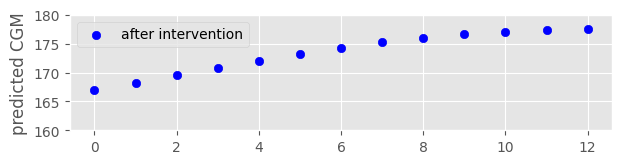

In [115]:
X_sample[0,np.argmax(X_sample[0,:,4]),4] = 25.0
fig, axs = plt.subplots(figsize=(7,1.5))
plt.scatter(np.arange(0,13,1),model.predict(X_sample)[0],c='blue')
plt.ylabel('predicted CGM')
plt.legend(['after intervention'],loc='upper left')
plt.ylim([160,180])

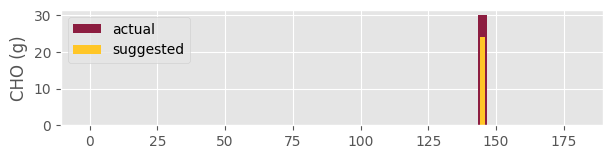

In [116]:
X_sample[0,np.argmax(X_sample[0,:,4]),4] = 30
fig, axs = plt.subplots(figsize=(7,1.5))
plt.bar(np.arange(0,180,1),X_sample[0,:,4], color='#8C1D40', width = 3)
X_sample[0,np.argmax(X_sample[0,:,4]),4] = 24
plt.bar(np.arange(0,180,1),X_sample[0,:,4], color='#FFC627', width = 2)
plt.ylabel('CHO (g)')
plt.legend(['actual','suggested'])
plt.show()